In [1]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
from math import sqrt, pi

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm
from copy import deepcopy

def sq_cost (X, Y):
    return (X-Y).square().flatten(start_dim=1).mean(dim=1)

## Min Config

In [14]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EXPERIMENT = 'WIFI' # 'WIFI', ACCEPT'
COST = sq_cost
T_ITERS = 10 # how much T updates to do per 1 update of f

if EXPERIMENT == 'ACCEPT':
    MAX_STEPS = 70000 # total number of training steps
    W = 2 # 2/2, 2/1
elif EXPERIMENT == 'WIFI':
    MAX_STEPS = 20000
    W = 3/2 # 3/3, 3/2, 3/1

In [15]:
# Use these functions to sample from the distributions

def sample_from_tensor(t, size=64):
    coords = (torch.rot90(t, -1, [0, 1]) == 1).nonzero(as_tuple=False).detach().cpu().numpy() / 32 / 32 - 1
    indices = random.choices(range(len(coords)), k=size)
    xy = coords[indices]
    return xy.astype(np.float32)

def sample_mixture_sphere(size=64, centerX=0, centerY=0, R=0.7, eps=0.1):
    Rs = np.array([(1,), (1.3,), (1.6,)])
    indices = random.choices(range(len(Rs)), k=size)
    radiuses = Rs[indices] + (np.random.random(size=(size, 1)) - 1) * eps
    theta = np.random.random(size=(size, 1)) * pi * 0.5
    x = centerX + radiuses * np.cos(theta)
    y = centerY + radiuses * np.sin(theta)
    return np.concatenate((x, y), axis=1).astype(np.float32)

def sample_normal(size=64, loc=(0, 0), scale=(0.2, 0.2)):
    return np.random.normal(size=(size,2), loc=loc, scale=scale).astype(np.float32)

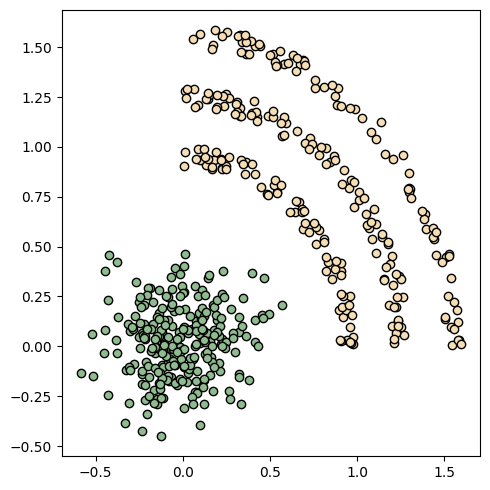

In [16]:
if EXPERIMENT == 'ACCEPT':
    im = Image.open('../pics/donotaccept.png')
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((32*32, 64*32)),
                                   ])
    t = transform(im)[0].float()
    t = (t < 0.5).float()
    
    X = sample_normal(2048, loc=(0, -2), scale=(0.5, 0.2))
    Y = sample_from_tensor(t, 2048)
    fig, axes = plt.subplots(1, 1, figsize=(10, 5), dpi=50, sharex=True, sharey=True)
elif EXPERIMENT == 'WIFI':
    X = sample_normal(256)
    Y = sample_mixture_sphere(256)
    fig, axes = plt.subplots(1, 1, figsize=(5,5), dpi=100, sharex=True, sharey=True)
    
axes.scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black')
axes.scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
fig.tight_layout()

## Initializing networks

In [17]:
class NegAbs(nn.Module):
    def __init__(self):
        super(NegAbs, self).__init__()

    def forward(self, input):
        return -torch.abs(input)
        
if EXPERIMENT == 'ACCEPT':
    T = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 2),
    ).to(DEVICE)

    f = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 1),
        NegAbs(),
    ).to(DEVICE)
elif EXPERIMENT == 'WIFI':
    T = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(True),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Linear(128, 2),
    ).to(DEVICE)

    f = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(True),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Linear(128, 128),
        nn.ReLU(True),
        nn.Linear(128, 1),
        NegAbs(),
    ).to(DEVICE)
    
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 33666
f params: 33537


In [18]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [19]:
if EXPERIMENT == 'ACCEPT':
    # Fixed samples for plotting
    X_fixed = sample_normal(2048, loc=(0, -2), scale=(0.5, 0.2))
    Y_fixed = sample_from_tensor(t, 2048)
elif EXPERIMENT == 'WIFI':
    # Fixed samples for plotting
    X_fixed, Y_fixed = sample_normal(256), sample_mixture_sphere(256)

## Training

Step 19800


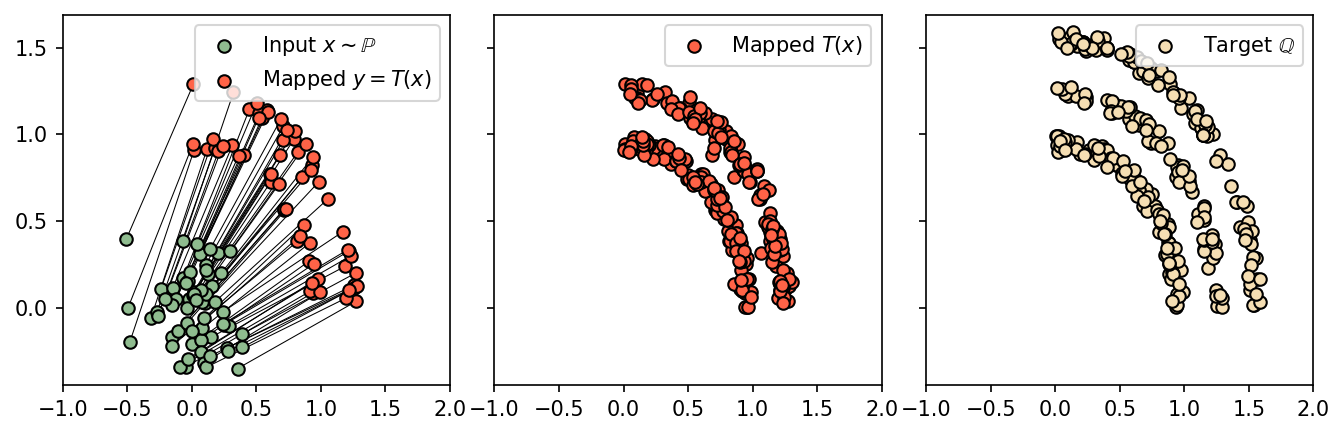

In [20]:
# NOT perfect algorithm
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        if EXPERIMENT == 'ACCEPT':
            X = sample_normal(4096, loc=(0, -2), scale=(0.5, 0.2))
        elif EXPERIMENT == 'WIFI':
            X = sample_normal(256)
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    if EXPERIMENT == 'ACCEPT':
        X = sample_normal(4096, loc=(0, -2), scale=(0.5, 0.2))
        Y = sample_from_tensor(t, 4096)
    elif EXPERIMENT == 'WIFI':
        X, Y = sample_normal(256), sample_mixture_sphere(256)

    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - (W * f(Y)).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
        X_fixed = torch.tensor(X_fixed, device=DEVICE)
        with torch.no_grad():
            T_X_fixed = T(X_fixed).to('cpu').numpy()
            X_fixed = X_fixed.to('cpu').numpy()
        lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
        lc = mc.LineCollection(lines, linewidths=0.5, color='black')
        axes[0].add_collection(lc)

        axes[0].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
        axes[0].scatter(T_X_fixed[:64,0], T_X_fixed[:64, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
        axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', label=r'Mapped $T(x)$')
        axes[2].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')
        axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')

        if EXPERIMENT == 'ACCEPT':
            axes[0].set_xlim(-1.2, 1.2);
        elif EXPERIMENT == 'WIFI':
            axes[0].set_xlim(-1, 2);
        fig.tight_layout(); plt.show()

## Evaluation

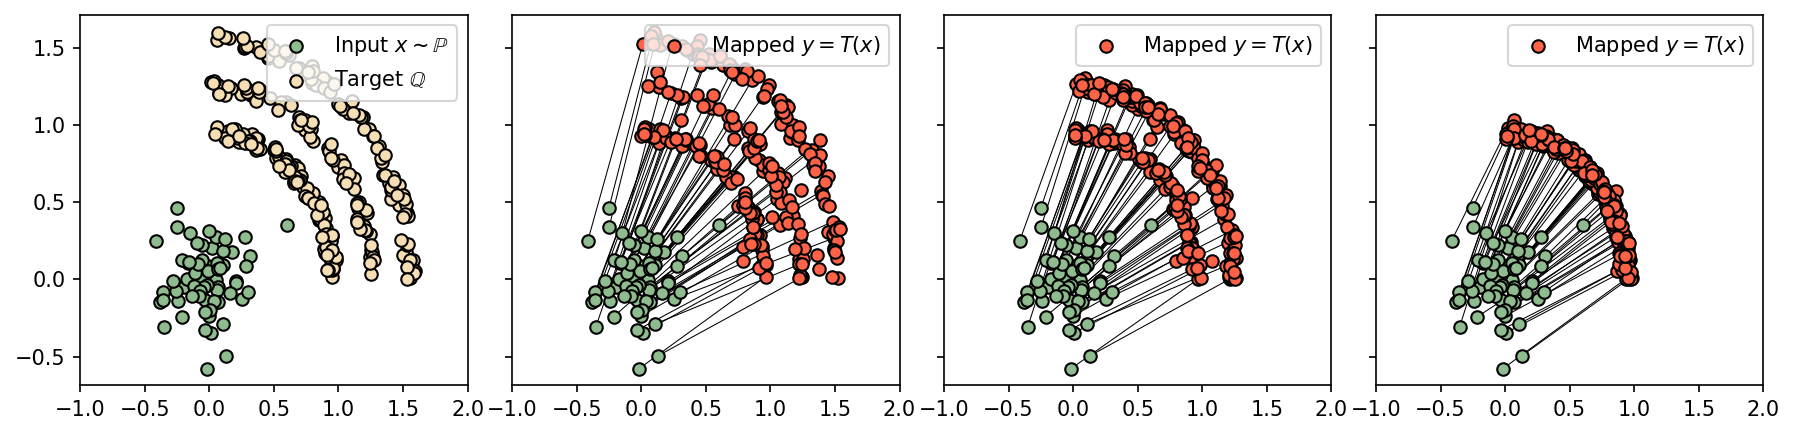

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(12,3), dpi=150, sharex=True, sharey=True)

T.eval();
X_fixed = sample_normal(256)

axes[0].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')

X_fixed = torch.tensor(X_fixed).to(DEVICE)
T.load_state_dict(torch.load('../checkpoints/wifi_IT_T_1.0.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[1].add_collection(lc)
axes[1].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

T.load_state_dict(torch.load('../checkpoints/wifi_IT_T_1.5.pth'))
with torch.no_grad():
    X_fixed = torch.tensor(X_fixed).cuda()
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
    lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[2].add_collection(lc)
axes[2].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[2].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

T.load_state_dict(torch.load('../checkpoints/wifi_IT_T_3.0.pth'))
with torch.no_grad():
    X_fixed = torch.tensor(X_fixed).cuda()
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
    lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[3].add_collection(lc)
axes[3].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[3].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); 
axes[2].legend(loc='upper right'); axes[3].legend(loc='upper right')

axes[0].set_xlim(-1, 2);
fig.tight_layout(); plt.show()

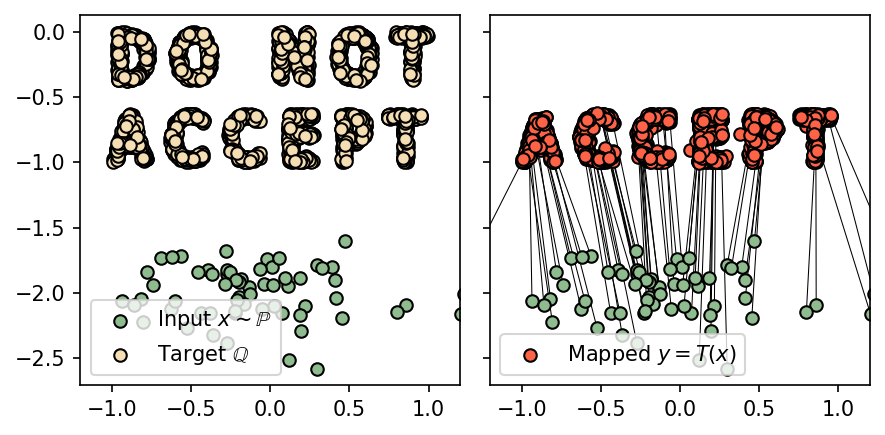

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=150, sharex=True, sharey=True)

X_fixed = sample_normal(2048, loc=(0, -2), scale=(0.5, 0.2))
T.eval();
axes[0].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')

X_fixed = torch.tensor(X_fixed).to(DEVICE)
T.load_state_dict(torch.load('../checkpoints/accept_IT_T_2.0.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[1].add_collection(lc)
axes[1].scatter(X_fixed[:64,0], X_fixed[:64, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

axes[0].legend(loc='lower left'); axes[1].legend(loc='lower left'); 

axes[0].set_xlim(-1.2, 1.2);
fig.tight_layout(); plt.show()